## analyse some of the phage scope data
Goal to check for if there is overfitting that is occuring 

In [8]:
# imports
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
os.chdir('/home/grig0076/GitHubs/Phynteny_transformer/')
from src import model_onehot
import torch
import umap
import matplotlib.pyplot as plt
import numpy as np 
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

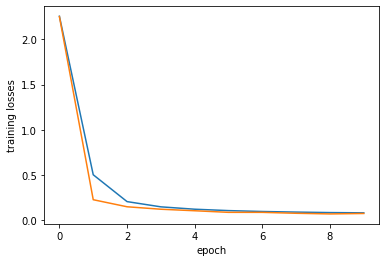

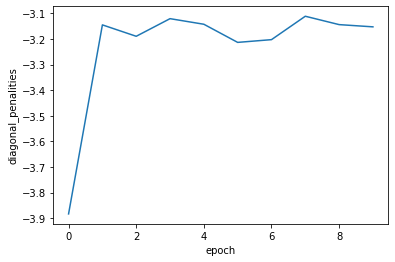

In [3]:
# analyse the training and validation loss 
metrics = pd.read_csv('/home/grig0076/scratch/Phynteny_transformer/PhageScope/17012024_maskfixed_PhageScope_entire_test_singlefold_batchsize_16_10epoch/fold_4/metrics.csv')
metrics['diagonal_penalities'] = np.log10(metrics['diagonal_penalities'])

sns.lineplot(data=metrics, x = 'epoch', y = 'training losses') 
sns.lineplot(data=metrics, x = 'epoch', y = 'validation losses') 
plt.show()

sns.lineplot(data=metrics, x = 'epoch', y = 'diagonal_penalities') # I think the lambda penalty wasn't set high enough here 
plt.show() 

in this case here - the model is actually learning to focus on the diagonal more rather than learning to avoid it! 
This is why plotting this curve is important 

In [10]:
# read in the validation data 
val_data = pickle.load(open('/home/grig0076/scratch/Phynteny_transformer/PhageScope/17012024_maskfixed_PhageScope_entire_test_singlefold_batchsize_16_10epoch/fold_4/val_kfold_loader.pkl','rb'))

# read in the model 
m = model_onehot.Seq2SeqTransformerClassifierRelativeAttention(input_dim=1293, num_classes=9, num_heads=4, hidden_dim=256, dropout=0.1)
m.load_state_dict(torch.load('/home/grig0076/scratch/Phynteny_transformer/PhageScope/17012024_maskfixed_PhageScope_entire_test_singlefold_batchsize_16_10epoch/fold_4transformer.model',  map_location=torch.device('cpu')))               
m.eval()

device='cpu'

In [ ]:
# Build ROC curve and Precision Recall Curves 

## Build the precision Recall curve as well 


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


<ipython-input-11-6716f54cebeb>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


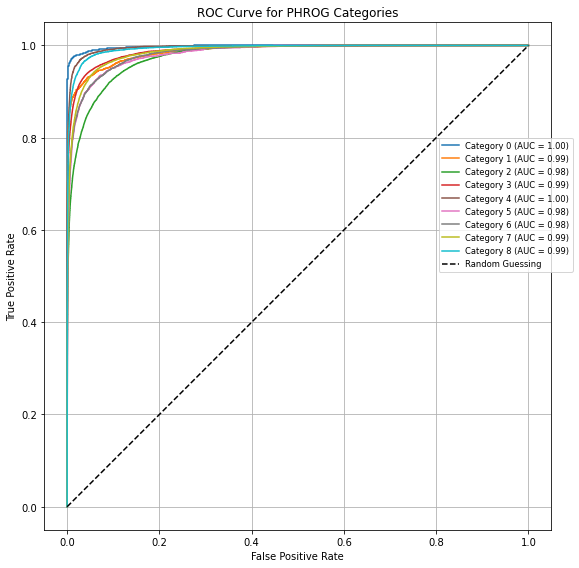

In [11]:
# Initialize accumulators for all batches
all_probs = []  # To store probability vectors for all sequences
all_categories = []  # To store ground truth labels

batches = 0 

# Loop through validation data
for embeddings, categories, masks, idx in val_data:
    batch_size = embeddings.shape[0]
    embeddings, categories, masks = (
        embeddings.to(device).float(),
        categories.to(device).long(),
        masks.to(device).float(),
    )
    src_key_padding_mask = (masks != -2)  # Masking for non-padding elements
    outputs = m(embeddings, src_key_padding_mask=src_key_padding_mask.to(device))  # Model prediction
    
    # Apply softmax to get probabilities
    probs = F.softmax(outputs, dim=2)
    
    # Collect masked outputs
    for i in range(batch_size):
        all_probs.extend(probs[i][idx[i]].tolist())  # Save the full probability vector
        all_categories.extend(categories[i][idx[i]].tolist())  # Save ground truth labels
        
    batches+=1 
    if batches % 100 ==0: 
        print(batches)

# Convert to numpy arrays for processing
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_categories = np.array(all_categories)  # Shape: (num_samples,)

# One-hot encode ground truth categories
num_classes = 9  # Update if you have more/less classes
y_true = label_binarize(all_categories, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each category
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all categories
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    label = f"{phrog_categories[i]} (AUC = {roc_auc[i]:.2f})"
    plt.plot(
        fpr[i],
        tpr[i],
        label=label,
        color=colors(i),
    )

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")

# Set square aspect ratio
plt.gca().set_aspect("equal", adjustable="box")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for PHROG Categories")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Initialize accumulators for all batches
all_probs = []  # To store probability vectors for all sequences
all_categories = []  # To store ground truth labels

batches = 0

# Loop through validation data
for embeddings, categories, masks, idx in val_data:
    batch_size = embeddings.shape[0]
    embeddings, categories, masks = (
        embeddings.to(device).float(),
        categories.to(device).long(),
        masks.to(device).float(),
    )
    src_key_padding_mask = (masks != -2)  # Masking for non-padding elements
    outputs = m(embeddings, src_key_padding_mask=src_key_padding_mask.to(device))  # Model prediction
    
    # Apply softmax to get probabilities
    probs = F.softmax(outputs, dim=2)
    
    # Collect masked outputs
    for i in range(batch_size):
        all_probs.extend(probs[i][idx[i]].tolist())  # Save the full probability vector
        all_categories.extend(categories[i][idx[i]].tolist())  # Save ground truth labels
        
    batches += 1
    if batches % 100 == 0:
        print(batches)

# Convert to numpy arrays for processing
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_categories = np.array(all_categories)  # Shape: (num_samples,)

# One-hot encode ground truth categories
num_classes = 9  # Update if you have more/less classes
y_true = label_binarize(all_categories, classes=np.arange(num_classes))

# Compute PR curve and Average Precision (AP) for each category
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], all_probs[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], all_probs[:, i])

# Plot PR curves for all categories
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    label = f"{phrog_categories[i]} (AP = {average_precision[i]:.2f})"
    plt.plot(
        recall[i],
        precision[i],
        label=label,
        color=colors(i),
    )

# Plot random baseline
# Set square aspect ratio
plt.gca().set_aspect("equal", adjustable="box")
plt.plot([0, 1], [1, 0], "k--", label="Random Guessing")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for PHROG Categories")
plt.legend(loc="lower left", bbox_to_anchor=(1.05, 0.5), fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()


100
200
300
